# Оценка качества RAG систем

Практическое занятие по оценке качества RAG систем с использованием RAGAS и LangSmith

## Установка зависимостей

In [3]:
%pip install -qU langchain langchain-openai langchain-community langchain-core langchain-text-splitters
%pip install -qU pypdf python-dotenv
%pip install -qU langsmith ragas datasets sentence-transformers pandas
%pip install matplotlib


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Настройка окружения

In [5]:
import os

SAFE_KEYS = ('LANGCHAIN_TRACING_V2','LANGCHAIN_ENDPOINT','LANGCHAIN_PROJECT','LANGSMITH_ENDPOINT','LANGSMITH_PROJECT')
for k in SAFE_KEYS:
    if k in os.environ:
        print(f'{k}: {os.environ[k]}')
if os.getenv('LANGCHAIN_API_KEY'):
    print('LANGCHAIN_API_KEY: <set>')
if os.getenv('LANGSMITH_API_KEY'):
    print('LANGSMITH_API_KEY: <set>')


✓ Окружение настроено


In [6]:
from pathlib import Path
from typing import List, Dict, Any
import json

from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_community.vectorstores import InMemoryVectorStore
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser

from langsmith import Client
from ragas import evaluate
from ragas.metrics import (
    Faithfulness,
    AnswerRelevancy,
    AnswerCorrectness,
    AnswerSimilarity,
    ContextRecall,
    ContextPrecision,
)
# Используем LangChain обертки (работают, хотя и deprecated)
# Новые методы вызывают ошибки совместимости с instructor
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from datasets import Dataset

print("✓ Все импорты успешны")

✓ Все импорты успешны


## 1. Подготовка: Создание базовых RAG пайплайнов

Создадим несколько вариантов RAG пайплайнов с разными моделями для сравнения качества.

### 1.1 Загрузка и индексация документов

In [7]:
def load_pdf_documents(data_dir: str) -> List:
    """Загрузка всех PDF документов из директории"""
    pages = []
    data_path = Path(data_dir)
    
    if not data_path.exists():
        raise FileNotFoundError(f"Директория {data_dir} не найдена")
    
    pdf_files = list(data_path.glob("*.pdf"))
    print(f"Найдено {len(pdf_files)} PDF файлов в {data_dir}")
    
    for pdf_file in pdf_files:
        loader = PyPDFLoader(str(pdf_file))
        pages.extend(loader.load())
        print(f"  Загружен: {pdf_file.name}")
    
    return pages

def split_documents(pages: List, chunk_size: int = 500, chunk_overlap: int = 50) -> List:
    """Разбиение документов на чанки"""
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap
    )
    chunks = text_splitter.split_documents(pages)
    print(f"Создано {len(chunks)} чанков")
    return chunks

# Загружаем документы
# Путь к данным относительно notebook
data_dir = "documents"
pages = load_pdf_documents(data_dir)
chunks = split_documents(pages)

Найдено 3 PDF файлов в documents
  Загружен: smirnoff_ai.pdf
  Загружен: ouk_potrebitelskiy_kredit_lph.pdf
  Загружен: usl_r_vkladov.pdf
Создано 423 чанков


### 1.2 Создание RAG пайплайнов с разными моделями

In [ ]:
def create_rag_pipeline(
    chunks: List,
    embedding_model: str,
    llm_model: str,
    k: int = 3,
    temperature: float = 0.0
) -> Dict[str, Any]:
    """
    Создание RAG пайплайна с заданными моделями
    
    Args:
        chunks: список документов для индексации
        embedding_model: модель для эмбеддингов
        llm_model: языковая модель для генерации ответов
        k: количество документов для retrieval
        temperature: температура для LLM (0.0 = детерминированный, 1.0+ = креативный)
    
    Returns:
        dict с ключами: retriever, rag_chain, config
        
        rag_chain возвращает dict с ключами:
        - answer: сгенерированный текстовый ответ
        - documents: список Document объектов из retriever
    """
    # Создание векторного хранилища
    embeddings = OpenAIEmbeddings(model=embedding_model)
    vector_store = InMemoryVectorStore.from_documents(
        documents=chunks,
        embedding=embeddings
    )
    
    # Создание retriever
    retriever = vector_store.as_retriever(search_kwargs={"k": k})
    
    # Промпт для ответа
    SYSTEM_TEMPLATE = """
Ты помощник для ответов на вопросы на основе предоставленного контекста.
Используй только информацию из контекста для ответа.
Если ответа нет в контексте, скажи "Я не нашел ответа на ваш вопрос в предоставленных документах".
Будь кратким и точным.

Контекст:
{context}
    """
    
    prompt = ChatPromptTemplate.from_messages([
        ("system", SYSTEM_TEMPLATE),
        ("human", "{question}"),
    ])
    
    # LLM
    llm = ChatOpenAI(model=llm_model, temperature=temperature)
    
    # RAG цепочка с сохранением документов
    # RAG цепочка состоит из трех последовательных шагов, соединенных оператором |
    rag_chain = (
        # Шаг 1: Получаем релевантные документы из retriever
        # RunnablePassthrough.assign() добавляет новое поле "documents" к входному словарю
        # При этом все существующие поля (например, "question") сохраняются
        # lambda x: retriever.invoke(x["question"]) - берет вопрос из входа и ищет похожие документы
        RunnablePassthrough.assign(
            documents=lambda x: retriever.invoke(x["question"]),
        )
        # Шаг 2: Генерируем ответ на основе найденных документов
        # Снова используем RunnablePassthrough.assign() для добавления поля "answer"
        # Теперь в x уже есть и "question", и "documents" из предыдущего шага
        | RunnablePassthrough.assign(
            # Внутри lambda создаем подцепочку: prompt | llm | StrOutputParser()
            # 1. Форматируем контекст: объединяем содержимое всех документов через \n\n
            # 2. Передаем в prompt вопрос и отформатированный контекст
            # 3. LLM генерирует ответ на основе промпта
            # 4. StrOutputParser() извлекает текст ответа из объекта LLM
            answer=lambda x: (prompt | llm | StrOutputParser()).invoke({
                "context": "\n\n".join(doc.page_content for doc in x["documents"]),
                "question": x["question"]
            })
        )
        # Шаг 3: Формируем финальный результат
        # lambda x: {...} - берет словарь со всеми полями и возвращает только нужные
        # Оставляем только "answer" (текст ответа) и "documents" (список Document объектов)
        # Это упрощает работу с результатом и делает интерфейс чище
        | (lambda x: {"answer": x["answer"], "documents": x["documents"]})
    )
    
    return {
        "retriever": retriever,  # возвращаем retriever для отладки и экспериментов
        "rag_chain": rag_chain,
        "config": {
            "embedding_model": embedding_model,
            "llm_model": llm_model,
            "k": k,
            "temperature": temperature
        }
    }

print("✓ Функция создания пайплайна готова (answer как основной output)")

✓ Функция создания пайплайна готова (answer как основной output)


### 1.3 Создание двух вариантов пайплайнов

In [19]:
# Пайплайн 1: Более слабая конфигурация
pipeline_1 = create_rag_pipeline(
    chunks=chunks,
    embedding_model="text-embedding-ada-002",  # Старая модель
    llm_model="gpt-3.5-turbo",  # Более простая модель
    k=1,  # Только 1 документ в контексте (минимум информации)
    temperature=2.0  # Максимальная креативность (очень непредсказуемый)
)
print(f"✓ Пайплайн 1 создан: {pipeline_1['config']}")

# Пайплайн 2: Более сильная конфигурация
pipeline_2 = create_rag_pipeline(
    chunks=chunks,
    embedding_model="text-embedding-3-large",  # Новая модель
    llm_model="gpt-4.1",  # Более мощная модель
    k=3,
    temperature=0.0  # Детерминированный режим (максимальная точность)
)
print(f"✓ Пайплайн 2 создан: {pipeline_2['config']}")

# Сохраняем пайплайны в словарь для удобства
pipelines = {
    "pipeline_1_weak": pipeline_1,
    "pipeline_2_strong": pipeline_2
}

✓ Пайплайн 1 создан: {'embedding_model': 'text-embedding-ada-002', 'llm_model': 'gpt-3.5-turbo', 'k': 1, 'temperature': 2.0}
✓ Пайплайн 2 создан: {'embedding_model': 'text-embedding-3-large', 'llm_model': 'gpt-4.1', 'k': 3, 'temperature': 0.0}


### 1.4 Тестирование пайплайнов

In [20]:
# Тестовый вопрос
test_question = "А что нужно для открытия вклада онлайн?"

print(f"Вопрос: {test_question}\n")

for name, pipeline in pipelines.items():
    print(f"--- {name} ---")
    result = pipeline["rag_chain"].invoke({"question": test_question})
    print(f"Ответ: {result['answer'][:200]}...")
    print(f"Источников: {len(result['documents'])}")
    print()

Вопрос: А что нужно для открытия вклада онлайн?

--- pipeline_1_weak ---
Ответ: Для открытия вклада онлайн через «Сбербанк Онлайн» необходимо осуществить безналичный перевод денежных средств со счета Вкладчика, открытого в Банке, на основании распоряжений Вкладчика на открытие сч...
Источников: 1

--- pipeline_2_strong ---
Ответ: Для открытия вклада онлайн в ПАО Сбербанк необходимо:

- Корректная идентификация и аутентификация Вкладчика/Представителя в соответствии с Договором банковского обслуживания или Договором о предостав...
Источников: 3



### 1.5 Трейсинг в LangSmith

Благодаря переменным окружения, **все наши вызовы к LangChain автоматически логируются в LangSmith**.

**Необходимые переменные окружения в `.env` файле:**
```bash
LANGSMITH_API_KEY=lsv2_pt_...           # API ключ из LangSmith
LANGSMITH_TRACING_V2=true               # Включить трейсинг
LANGSMITH_PROJECT=my-rag-project        # Название проекта (опционально)
```

**Что даёт автоматический трейсинг:**
- 🔍 Просматривать детальные трейсы каждого запроса в LangSmith UI
- 📊 Анализировать latency, token usage, промежуточные шаги
- 🐛 Отлаживать проблемы в RAG пайплайнах
- 📈 Мониторить производительность в реальном времени
- 💰 Отслеживать стоимость API вызовов

**Пример трейса RAG пайплайна в LangSmith UI:**

![LangSmith Trace](./langsmith_trace.png)

На скриншоте видно детальный трейс выполнения RAG пайплайна:

**Левая панель (TRACE) - структура выполнения:**
- `RunnableSequence` - главная цепочка (5.03s, 603 tokens)
- `RunnableAssign<documents>` - этап retrieval с VectorStoreRetriever (0.56s)
- `RunnableAssign<answer>` - этап генерации ответа (4.48s)
  - `ChatPromptTemplate` - формирование промпта (0.00s)
  - `ChatOpenAI` (gpt-4.1) - вызов LLM (4.47s, 603 tokens)
  - `StrOutputParser` - парсинг ответа (0.00s)

**Правая панель - детали выполнения:**
- **Input** - вопрос пользователя
- **Output** - результат с `documents` (3 retrieved документа) и `answer`
- **Статистика**: 603 tokens / $0.002106, Latency: 5.03s
- **Metadata** - информация о пайплайне

Это позволяет видеть каждый шаг RAG пайплайна, время выполнения, стоимость и промежуточные результаты!


## 2. Создание датасета для оценки

Создадим ground truth датасет на основе документов.

### 2.1 Синтез вопросов и ответов на основе документов

In [21]:
def synthesize_qa_pairs_from_chunks(
    chunks: List,
    llm_model: str = "gpt-4.1",
    num_questions_per_chunk: int = 1
) -> List[Dict[str, Any]]:
    """
    Синтез вопросов и ответов на основе чанков документов
    
    Returns:
        List of dicts with keys: question, ground_truth, contexts
    """
    llm = ChatOpenAI(model=llm_model, temperature=0.7)
    
    synthesis_prompt = ChatPromptTemplate.from_messages([
        ("system", """
Ты эксперт по созданию вопросно-ответных пар для оценки RAG систем.
На основе предоставленного текста создай {num_questions} разнообразных вопросов,
на которые можно ответить используя этот текст.

Вопросы должны быть:
- Реалистичными (такие вопросы могут задать реальные пользователи)
- Разнообразными (разные типы: фактологические, сравнительные, уточняющие)
- Конкретными (можно дать точный ответ на основе текста)

Для каждого вопроса также создай краткий точный ответ на основе текста.

ВАЖНО: Верни ТОЛЬКО валидный JSON без дополнительного текста:
{{
  "qa_pairs": [
    {{"question": "...", "answer": "..."}},
    ...
  ]
}}
        """),
        ("human", "Текст:\n{chunk_text}")
    ])
    
    qa_pairs = []
    
    # Обрабатываем каждый чанк
    for i, chunk in enumerate(chunks):
        if len(chunk.page_content.strip()) < 100:  # Пропускаем слишком короткие чанки
            continue
            
        try:
            response = llm.invoke(
                synthesis_prompt.format_messages(
                    num_questions=num_questions_per_chunk,
                    chunk_text=chunk.page_content[:2000]  # Ограничиваем длину
                )
            )
            
            # Парсим JSON ответ
            content = response.content.strip()
            
            # Извлекаем JSON из ответа (может быть обернут в markdown)
            if "```json" in content:
                content = content.split("```json")[1].split("```")[0].strip()
            elif "```" in content:
                # Пробуем извлечь из любого code block
                parts = content.split("```")
                if len(parts) >= 2:
                    content = parts[1].strip()
                    if content.startswith("json"):
                        content = content[4:].strip()
            
            # Убираем возможные префиксы/суффиксы
            content = content.strip()
            if not content.startswith("{"):
                # Ищем первую открывающую скобку
                idx = content.find("{")
                if idx >= 0:
                    content = content[idx:]
            
            data = json.loads(content)
            
            for qa in data.get("qa_pairs", []):
                if "question" in qa and "answer" in qa:
                    qa_pairs.append({
                        "question": qa["question"],
                        "ground_truth": qa["answer"],
                        "contexts": [chunk.page_content],  # Релевантный контекст
                        "metadata": {
                            "source": chunk.metadata.get("source", "unknown"),
                            "page": chunk.metadata.get("page", -1)
                        }
                    })
            
            if (i + 1) % 10 == 0:
                print(f"Обработано {i + 1}/{len(chunks)} чанков, создано {len(qa_pairs)} QA пар")
                
        except json.JSONDecodeError as e:
            print(f"Ошибка парсинга JSON для чанка {i}: {e}")
            print(f"Ответ LLM: {content[:200]}...")
            continue
        except Exception as e:
            print(f"Ошибка при обработке чанка {i}: {e}")
            continue
    
    print(f"\nВсего создано {len(qa_pairs)} QA пар")
    return qa_pairs

print("✓ Функция синтеза QA пар готова")

✓ Функция синтеза QA пар готова


### 2.2 Генерация датасета (может занять время)

In [22]:
# Создаем датасет (для демонстрации используем ограниченное количество чанков)
# В реальности можно обработать все чанки
# Разделим все чанки на группы и возьмем по одному чанку из каждой группы
num_samples = 4  # Требуемое количество чанков
group_size = len(chunks) // num_samples
sample_chunks = [chunks[i * group_size] for i in range(num_samples)]

qa_dataset = synthesize_qa_pairs_from_chunks(
    chunks=sample_chunks
)

print(f"\nСоздано {len(qa_dataset)} примеров в датасете")
if qa_dataset:
    print(f"\nПример первого вопроса:")
    print(json.dumps(qa_dataset[0], ensure_ascii=False, indent=2))


Всего создано 4 QA пар

Создано 4 примеров в датасете

Пример первого вопроса:
{
  "question": "Какие типы ИИ-решений предлагаются для бизнеса согласно тексту?",
  "ground_truth": "Предлагаются системы искусственного интеллекта, ИИ-ассистенты, ИИ-агенты, ИИ-боты и другие решения на базе генеративного искусственного интеллекта.",
  "contexts": [
    "Профессиональная  разработка  ИИ-решений  для  бизнеса  \nПрофессиональная  разработка  и  внедрение  систем  искусственного  интеллекта,  ИИ-ассистентов,  ИИ-агентов,  ИИ-ботов  и  других  решений  на  базе  генеративного  искусственного  интеллекта  для  частных  клиентов,  малого  и  среднего  бизнеса."
  ],
  "metadata": {
    "source": "documents/smirnoff_ai.pdf",
    "page": 0
  }
}


## 3. RAGAS. Оценка качества RAG пайплайнов

Оценим качество каждого пайплайна с помощью RAGAS метрик.

### 3.1 Функция оценки качества

In [23]:
def evaluate_rag_pipeline(
    pipeline: Dict[str, Any],
    qa_pairs: List[Dict[str, Any]],
    pipeline_name: str
) -> Dict[str, Any]:
    """
    Оценка качества RAG пайплайна с помощью RAGAS
    
    Returns:
        dict с результатами оценки
    """
    print(f"\nОценка пайплайна: {pipeline_name}")
    
    # Получаем ответы от пайплайна для всех вопросов
    questions = []
    answers = []
    ground_truths = []
    contexts_list = []
    
    for qa in qa_pairs:
        question = qa["question"]
        
        # Получаем ответ и документы от пайплайна одним вызовом
        result = pipeline["rag_chain"].invoke({"question": question})
        answer = result["answer"]
        retrieved_chunks = result["documents"]
        contexts = [chunk.page_content for chunk in retrieved_chunks]
        
        questions.append(question)
        answers.append(answer)
        ground_truths.append(qa["ground_truth"])
        contexts_list.append(contexts)
    
    # Подготавливаем данные для RAGAS
    ragas_dataset = Dataset.from_dict({
        "question": questions,
        "answer": answers,
        "ground_truth": ground_truths,
        "contexts": contexts_list
    })
    
    # Используем фиксированные модели для RAGAS оценки (не из пайплайна)
    # Это обеспечивает единообразную оценку всех пайплайнов
    ragas_llm_model = "gpt-4.1"
    ragas_embedding_model = "text-embedding-3-large"
    
    # Создаем LangChain LLM и embeddings для RAGAS
    langchain_llm = ChatOpenAI(model=ragas_llm_model, temperature=0.0, n=1)
    langchain_embeddings = OpenAIEmbeddings(model=ragas_embedding_model)
    
    # Обертываем для RAGAS (deprecated, но работает стабильно)
    # Новые методы (llm_factory, OpenAIEmbeddings из ragas) вызывают ошибки совместимости
    ragas_llm = LangchainLLMWrapper(langchain_llm)
    ragas_embeddings = LangchainEmbeddingsWrapper(langchain_embeddings)
    
    # Инициализируем метрики с правильными параметрами
    # faithfulness, context_recall, context_precision: только llm
    # answer_similarity: только embeddings
    # answer_relevancy, answer_correctness: и llm, и embeddings
    # Устанавливаем strictness=1 для метрик, которые требуют несколько генераций
    # Это уменьшит количество запросов, но может немного снизить точность оценки
    answer_similarity_metric = AnswerSimilarity(embeddings=ragas_embeddings)
    
    metrics = [
        Faithfulness(llm=ragas_llm),
        AnswerRelevancy(llm=ragas_llm, embeddings=ragas_embeddings, strictness=1),  # Уменьшаем до 1 генерации
        AnswerCorrectness(
            llm=ragas_llm,
            embeddings=ragas_embeddings,
            answer_similarity=answer_similarity_metric
        ),
        answer_similarity_metric,
        ContextRecall(llm=ragas_llm),
        ContextPrecision(llm=ragas_llm),
    ]
    
    # Вычисляем метрики с явной передачей llm и embeddings
    # Добавляем RunConfig для обработки ошибок подключения (как в референсе)
    from ragas.run_config import RunConfig
    
    run_config = RunConfig(
        max_workers=1,  # Уменьшаем параллелизм для стабильности
        timeout=360,  # Увеличиваем таймаут до 6 минут
        max_retries=20,  # Увеличиваем количество попыток
        max_wait=120,  # Максимальное время ожидания между попытками
        log_tenacity=True  # Логируем попытки retry
    )
    
    result = evaluate(
        ragas_dataset,
        metrics=metrics,
        llm=ragas_llm,
        embeddings=ragas_embeddings,
        run_config=run_config,  # Добавляем конфигурацию для retry
    )
    
    # Извлекаем результаты (RAGAS возвращает результат в формате EvaluationResult)
    metrics_dict = {}
    for metric_name in ["faithfulness", "answer_relevancy", "answer_correctness", 
                       "answer_similarity", "context_recall", "context_precision"]:
        try:
            # Пробуем разные способы получения метрики
            scores = None
            if hasattr(result, metric_name):
                scores = getattr(result, metric_name)
            elif hasattr(result, '_scores_dict') and metric_name in result._scores_dict:
                scores = result._scores_dict[metric_name]
            elif isinstance(result, dict) and metric_name in result:
                scores = result[metric_name]
            else:
                # Пробуем получить через индексацию (если это Dataset или dict-like)
                try:
                    scores = result[metric_name]
                except (KeyError, TypeError, AttributeError):
                    continue
            
            if scores is not None:
                if isinstance(scores, list):
                    avg_score = sum(scores) / len(scores) if scores else 0
                else:
                    avg_score = float(scores) if scores is not None else 0
                metrics_dict[metric_name] = {
                    "scores": scores if isinstance(scores, list) else [scores],
                    "average": avg_score
                }
        except (KeyError, AttributeError, TypeError) as e:
            print(f"  Предупреждение: не удалось извлечь метрику {metric_name}: {e}")
            continue
    
    print(f"\nРезультаты оценки для {pipeline_name}:")
    for metric_name, values in metrics_dict.items():
        if isinstance(values, dict) and "average" in values:
            print(f"  {metric_name}: {values['average']:.3f}")
    
    return {
        "pipeline_name": pipeline_name,
        "metrics": metrics_dict,
        "config": pipeline["config"],
        "ragas_result": result  # Сохраняем полный результат для дальнейшего анализа
    }

print("✓ Функция оценки готова")

✓ Функция оценки готова


### 3.2 Оценка всех пайплайнов

In [24]:
evaluation_results = {}

for name, pipeline in pipelines.items():
    results = evaluate_rag_pipeline(
        pipeline=pipeline,
        qa_pairs=qa_dataset,  # Используем ограниченный датасет
        pipeline_name=name
    )
    evaluation_results[name] = results


Оценка пайплайна: pipeline_1_weak


/var/folders/_k/7q0q098s44bc8pbczmplf_8h0000gn/T/ipykernel_62743/2901206597.py:53: DeprecationWarning: LangchainLLMWrapper is deprecated and will be removed in a future version. Use llm_factory instead: from openai import OpenAI; from ragas.llms import llm_factory; llm = llm_factory('gpt-4o-mini', client=OpenAI(api_key='...'))
  ragas_llm = LangchainLLMWrapper(langchain_llm)
/var/folders/_k/7q0q098s44bc8pbczmplf_8h0000gn/T/ipykernel_62743/2901206597.py:54: DeprecationWarning: LangchainEmbeddingsWrapper is deprecated and will be removed in a future version. Use the modern embedding providers instead: embedding_factory('openai', model='text-embedding-3-small', client=openai_client) or from ragas.embeddings import OpenAIEmbeddings, GoogleEmbeddings, HuggingFaceEmbeddings
  ragas_embeddings = LangchainEmbeddingsWrapper(langchain_embeddings)


Evaluating:   0%|          | 0/24 [00:00<?, ?it/s]


Результаты оценки для pipeline_1_weak:
  faithfulness: 0.875
  answer_relevancy: 0.594
  answer_correctness: 0.536
  answer_similarity: 0.477
  context_recall: 0.833
  context_precision: 1.000

Оценка пайплайна: pipeline_2_strong


Evaluating:   0%|          | 0/24 [00:00<?, ?it/s]


Результаты оценки для pipeline_2_strong:
  faithfulness: 1.000
  answer_relevancy: 0.926
  answer_correctness: 0.857
  answer_similarity: 0.886
  context_recall: 1.000
  context_precision: 0.833


### 3.3 Сравнение результатов

Сравнение пайплайнов:
         Pipeline faithfulness answer_relevancy answer_correctness answer_similarity context_recall context_precision
  pipeline_1_weak        0.875            0.594              0.536             0.477          0.833             1.000
pipeline_2_strong        1.000            0.926              0.857             0.886          1.000             0.833


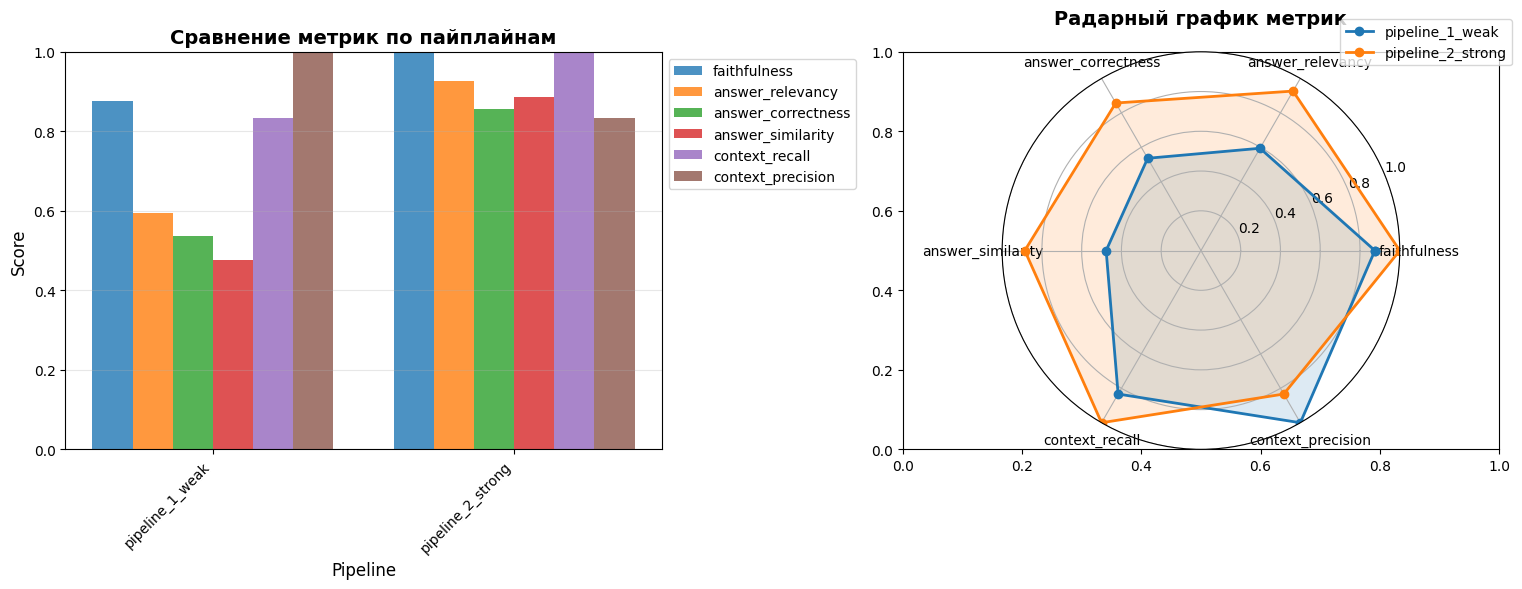

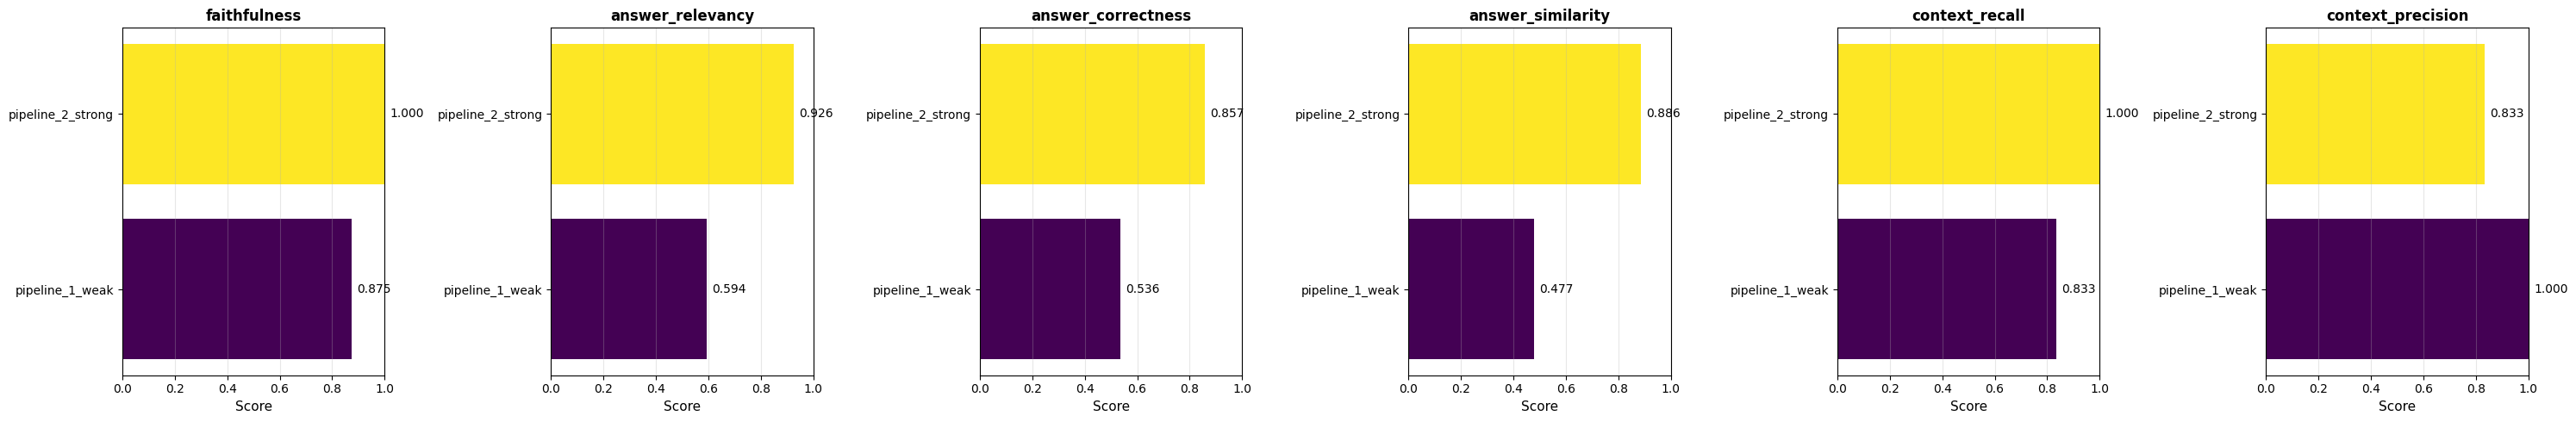

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Создаем таблицу сравнения
comparison_data = []

for name, results in evaluation_results.items():
    metrics = results["metrics"]
    row = {"Pipeline": name}
    
    for metric_name, values in metrics.items():
        if isinstance(values, dict) and "average" in values:
            row[metric_name] = values['average']
    
    comparison_data.append(row)

df_comparison = pd.DataFrame(comparison_data)

# Выводим таблицу
print("Сравнение пайплайнов:")
df_display = df_comparison.copy()
for col in df_display.columns:
    if col != "Pipeline":
        df_display[col] = df_display[col].apply(lambda x: f"{x:.3f}" if isinstance(x, (int, float)) else x)
print(df_display.to_string(index=False))

# Визуализация результатов
metric_columns = [col for col in df_comparison.columns if col != "Pipeline"]

if metric_columns:
    # График 1: Сравнение всех метрик для всех пайплайнов
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Барплот для сравнения метрик
    x = np.arange(len(df_comparison))
    width = 0.8 / len(metric_columns)
    
    for i, metric in enumerate(metric_columns):
        offset = width * i - (width * len(metric_columns) / 2 - width / 2)
        axes[0].bar(x + offset, df_comparison[metric], width, label=metric, alpha=0.8)
    
    axes[0].set_xlabel('Pipeline', fontsize=12)
    axes[0].set_ylabel('Score', fontsize=12)
    axes[0].set_title('Сравнение метрик по пайплайнам', fontsize=14, fontweight='bold')
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(df_comparison['Pipeline'], rotation=45, ha='right')
    axes[0].legend(loc='upper left', bbox_to_anchor=(1, 1))
    axes[0].grid(axis='y', alpha=0.3)
    axes[0].set_ylim(0, 1.0)
    
    # Радарный график для сравнения пайплайнов
    angles = np.linspace(0, 2 * np.pi, len(metric_columns), endpoint=False).tolist()
    angles += angles[:1]
    
    ax = plt.subplot(122, projection='polar')
    
    for idx, row in df_comparison.iterrows():
        values = [row[metric] for metric in metric_columns]
        values += values[:1]
        ax.plot(angles, values, 'o-', linewidth=2, label=row['Pipeline'])
        ax.fill(angles, values, alpha=0.15)
    
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(metric_columns, size=10)
    ax.set_ylim(0, 1.0)
    ax.set_title('Радарный график метрик', fontsize=14, fontweight='bold', pad=20)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    ax.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # График 2: Детальное сравнение по каждой метрике
    n_metrics = len(metric_columns)
    fig, axes = plt.subplots(1, n_metrics, figsize=(5 * n_metrics, 5))
    
    if n_metrics == 1:
        axes = [axes]
    
    for idx, metric in enumerate(metric_columns):
        axes[idx].barh(df_comparison['Pipeline'], df_comparison[metric], color=plt.cm.viridis(np.linspace(0, 1, len(df_comparison))))
        axes[idx].set_xlabel('Score', fontsize=11)
        axes[idx].set_title(metric, fontsize=12, fontweight='bold')
        axes[idx].set_xlim(0, 1.0)
        axes[idx].grid(axis='x', alpha=0.3)
        
        # Добавляем значения на графике
        for i, v in enumerate(df_comparison[metric]):
            axes[idx].text(v + 0.02, i, f'{v:.3f}', va='center', fontsize=10)
    
    plt.tight_layout()
    plt.show()

## 4. Интегрируем с LangSmith


### 4.1 Загрузка датасета в LangSmith

In [27]:
def upload_dataset_to_langsmith(
    qa_pairs: List[Dict[str, Any]],
    dataset_name: str,
    description: str = "RAG evaluation dataset"
) -> str:
    """
    Загружает датасет вопросов и ответов в LangSmith
    
    Args:
        qa_pairs: Список словарей с ключами 'question', 'ground_truth', 'contexts', 'metadata'
        dataset_name: Имя датасета в LangSmith
        description: Описание датасета
    
    Returns:
        ID созданного датасета
    """
    client = Client()
    
    # Преобразуем наш формат в формат LangSmith
    examples = []
    for qa in qa_pairs:
        example = {
            "inputs": {"question": qa["question"]},
            "outputs": {"answer": qa["ground_truth"]},
            "metadata": {
                **qa.get("metadata", {}),
                "contexts": qa.get("contexts", [])
            }
        }
        examples.append(example)
    
    # Создаем датасет
    dataset = client.create_dataset(
        dataset_name=dataset_name,
        description=description
    )
    
    # Загружаем примеры
    client.create_examples(
        dataset_id=dataset.id,
        examples=examples
    )
    
    print(f"✓ Датасет '{dataset_name}' создан в LangSmith")
    print(f"  ID датасета: {dataset.id}")
    print(f"  Загружено примеров: {len(examples)}")
    
    return dataset.id


In [ ]:
# Загружаем наш датасет в LangSmith
DATASET_NAME = "SBERAGENTS_RAG_EVALUATION_DATASET_V1"
dataset_id = upload_dataset_to_langsmith(
    qa_pairs=qa_dataset,
    dataset_name=DATASET_NAME,
    description="Вопросы и ответы для оценки качества RAG систем"
)


✓ Датасет 'SBERAGENTS_RAG_EVALUATION_DATASET_V1' создан в LangSmith
  ID датасета: 08dee2b9-21e6-45f1-bebb-b31dc2d92442
  Загружено примеров: 4


### 4.2 Просмотр списка датасетов


In [29]:
# Способ 1: Получить все датасеты
client = Client()
datasets = client.list_datasets()

# Преобразуем итератор в список, чтобы можно было использовать несколько раз
datasets_list = list(datasets)

print(f"Найдено датасетов: {len(datasets_list)}")


Найдено датасетов: 1


In [35]:
# Способ 2: Поиск датасета по имени
datasets = client.list_datasets(dataset_name=DATASET_NAME)

# Преобразуем итератор в список, чтобы можно было использовать несколько раз
datasets_list = list(datasets)

print(f"Найдено датасетов: {len(datasets_list)}")
for dataset in datasets_list:
    print(f"  - {dataset.name} (ID: {dataset.id})")
    if dataset.description:
        print(f"    Описание: {dataset.description}")
    print()


Найдено датасетов: 1
  - SBERAGENTS_RAG_EVALUATION_DATASET_V1 (ID: 08dee2b9-21e6-45f1-bebb-b31dc2d92442)
    Описание: Вопросы и ответы для оценки качества RAG систем



### 4.3 Оценка качества RAG с LangSmith

В этом разделе мы создадим кастомные эвалюаторы  на основе LLM-as-a-judge подхода для LangSmith, которые будут оценивать качество ответов RAG-системы.

#### Создание кастомных эвалюаторов

Эвалюаторы в LangSmith - это функции, которые принимают `inputs`, `outputs` и опционально `reference_outputs`, и возвращают оценку (bool, int или float). Мы используем подход LLM-as-a-judge с structured output для получения обоснованных оценок.


In [36]:
from typing_extensions import Annotated, TypedDict

# Grade output schema для correctness
class CorrectnessGrade(TypedDict):
    explanation: Annotated[str, ..., "Explain your reasoning for the score"]
    score: Annotated[float, ..., "Score from 0.0 to 1.0 indicating answer correctness"]

# Grade prompt для correctness
correctness_instructions = """You are a teacher grading a quiz. You will be given a QUESTION, the GROUND TRUTH (correct) ANSWER, and the STUDENT ANSWER. 

Grade the student answer based on factual accuracy relative to the ground truth answer.

Score:
- 1.0: Answer is completely correct and aligns with ground truth
- 0.7-0.9: Answer is mostly correct with minor inaccuracies or missing minor details
- 0.4-0.6: Answer is partially correct but has significant gaps or some incorrect information
- 0.1-0.3: Answer has major inaccuracies or is mostly incorrect
- 0.0: Answer is completely incorrect or off-topic

Note: It is OK if the student answer contains more information than the ground truth, as long as it is factually accurate.

Explain your reasoning in a step-by-step manner to ensure your reasoning and conclusion are correct."""

# Grader LLM для correctness
correctness_grader_llm = ChatOpenAI(model="gpt-4o", temperature=0).with_structured_output(
    CorrectnessGrade, method="json_schema", strict=True
)

def answer_correctness(inputs: dict, outputs: dict, reference_outputs: dict) -> float:
    """Эвалюатор для оценки правильности ответа относительно ground truth"""
    answers = f"""\
QUESTION: {inputs['question']}
GROUND TRUTH ANSWER: {reference_outputs['answer']}
STUDENT ANSWER: {outputs['answer']}"""
    # Run evaluator
    grade = correctness_grader_llm.invoke([
        {"role": "system", "content": correctness_instructions},
        {"role": "user", "content": answers}
    ])
    return float(grade["score"])


# Grade output schema для relevance
class RelevanceGrade(TypedDict):
    explanation: Annotated[str, ..., "Explain your reasoning for the score"]
    score: Annotated[float, ..., "Score from 0.0 to 1.0 indicating answer relevance"]

# Grade prompt для relevance
relevance_instructions = """You are a teacher grading a quiz. You will be given a QUESTION and a STUDENT ANSWER.

Evaluate how relevant and helpful the answer is for the question.

Score:
- 1.0: Answer is highly relevant, directly addresses the question, and is very helpful
- 0.7-0.9: Answer is relevant and mostly addresses the question with minor off-topic content
- 0.4-0.6: Answer is somewhat relevant but misses key aspects or has significant off-topic content
- 0.1-0.3: Answer is barely relevant, mostly off-topic or unhelpful
- 0.0: Answer is completely irrelevant or does not address the question at all

Explain your reasoning in a step-by-step manner to ensure your reasoning and conclusion are correct."""

# Grader LLM для relevance
relevance_grader_llm = ChatOpenAI(model="gpt-4o", temperature=0).with_structured_output(
    RelevanceGrade, method="json_schema", strict=True
)

def answer_relevancy(inputs: dict, outputs: dict) -> float:
    """Эвалюатор для оценки релевантности ответа вопросу"""
    answer = f"QUESTION: {inputs['question']}\nSTUDENT ANSWER: {outputs['answer']}"
    grade = relevance_grader_llm.invoke([
        {"role": "system", "content": relevance_instructions},
        {"role": "user", "content": answer}
    ])
    return float(grade["score"])


# Grade output schema для similarity
class SimilarityGrade(TypedDict):
    explanation: Annotated[str, ..., "Explain your reasoning for the score"]
    score: Annotated[float, ..., "Score from 0.0 to 1.0 indicating semantic similarity"]

# Grade prompt для similarity
similarity_instructions = """You are a teacher comparing two answers. You will be given a QUESTION, a REFERENCE ANSWER, and a STUDENT ANSWER.

Evaluate the semantic similarity between the student answer and the reference answer.

Score:
- 1.0: Answers convey exactly the same meaning, just with different wording
- 0.7-0.9: Answers convey very similar meaning with minor semantic differences
- 0.4-0.6: Answers share some common meaning but have notable semantic differences
- 0.1-0.3: Answers have little semantic overlap, mostly different meanings
- 0.0: Answers convey completely different meanings

Note: Focus on semantic meaning, not exact wording. Different words expressing the same idea should score high.

Explain your reasoning in a step-by-step manner to ensure your reasoning and conclusion are correct."""

# Grader LLM для similarity
similarity_grader_llm = ChatOpenAI(model="gpt-4o", temperature=0).with_structured_output(
    SimilarityGrade, method="json_schema", strict=True
)

def answer_similarity(inputs: dict, outputs: dict, reference_outputs: dict) -> float:
    """Эвалюатор для оценки семантической похожести ответа на ground truth"""
    answers = f"""\
QUESTION: {inputs['question']}
REFERENCE ANSWER: {reference_outputs['answer']}
STUDENT ANSWER: {outputs['answer']}"""
    # Run evaluator
    grade = similarity_grader_llm.invoke([
        {"role": "system", "content": similarity_instructions},
        {"role": "user", "content": answers}
    ])
    return float(grade["score"])

print("✓ Эвалюаторы LangSmith созданы (все возвращают float 0.0-1.0)")


# ============================================================================
# Эвалюаторы с использованием retrieved documents (contexts)
# ============================================================================

# Grade output schema для faithfulness (groundedness)
class FaithfulnessGrade(TypedDict):
    explanation: Annotated[str, ..., "Explain your reasoning for the score"]
    score: Annotated[float, ..., "Score from 0.0 to 1.0 indicating how grounded the answer is in the facts"]

# Grade prompt для faithfulness
faithfulness_instructions = """You are a teacher grading a quiz. You will be given FACTS and a STUDENT ANSWER. Here is the grade criteria to follow:
(1) Ensure the STUDENT ANSWER is grounded in the FACTS
(2) Ensure the STUDENT ANSWER does not contain "hallucinated" information outside the scope of the FACTS
(3) The student can use less information than provided, but cannot add information not in FACTS

Score:
- 1.0: Answer is fully grounded in the facts with no hallucinations
- 0.7-0.9: Answer is mostly grounded with minor unsupported details
- 0.4-0.6: Answer has significant unsupported information
- 0.1-0.3: Answer is mostly hallucinated
- 0.0: Answer is completely hallucinated

Explain your reasoning in a step-by-step manner to ensure your reasoning and conclusion are correct."""

# Grader LLM для faithfulness
faithfulness_grader_llm = ChatOpenAI(model="gpt-4o", temperature=0).with_structured_output(
    FaithfulnessGrade, method="json_schema", strict=True
)

def faithfulness(inputs: dict, outputs: dict) -> float:
    """Эвалюатор для оценки обоснованности ответа retrieved documents (groundedness)"""
    doc_string = "\n\n".join(doc.page_content for doc in outputs["documents"])
    answer = f"FACTS:\n{doc_string}\n\nSTUDENT ANSWER: {outputs['answer']}"
    grade = faithfulness_grader_llm.invoke([
        {"role": "system", "content": faithfulness_instructions},
        {"role": "user", "content": answer}
    ])
    return float(grade["score"])


# Grade output schema для context_precision (retrieval relevance)
class ContextPrecisionGrade(TypedDict):
    explanation: Annotated[str, ..., "Explain your reasoning for the score"]
    score: Annotated[float, ..., "Score from 0.0 to 1.0 indicating how relevant the retrieved documents are"]

# Grade prompt для context_precision
context_precision_instructions = """You are a teacher grading retrieved documents. You will be given a QUESTION and RETRIEVED FACTS. Here is the grade criteria to follow:
(1) Evaluate how relevant the FACTS are to answering the QUESTION
(2) Check if the FACTS contain information that directly helps answer the QUESTION
(3) Consider both relevance and precision of the retrieved information

Score:
- 1.0: All retrieved facts are highly relevant and precise for the question
- 0.7-0.9: Most facts are relevant with some less relevant information
- 0.4-0.6: Mix of relevant and irrelevant information
- 0.1-0.3: Mostly irrelevant facts
- 0.0: No relevant information retrieved

Explain your reasoning in a step-by-step manner to ensure your reasoning and conclusion are correct."""

# Grader LLM для context_precision
context_precision_grader_llm = ChatOpenAI(model="gpt-4o", temperature=0).with_structured_output(
    ContextPrecisionGrade, method="json_schema", strict=True
)

def context_precision(inputs: dict, outputs: dict) -> float:
    """Эвалюатор для оценки точности и релевантности retrieved documents"""
    doc_string = "\n\n".join(doc.page_content for doc in outputs["documents"])
    content = f"QUESTION: {inputs['question']}\n\nRETRIEVED FACTS:\n{doc_string}"
    grade = context_precision_grader_llm.invoke([
        {"role": "system", "content": context_precision_instructions},
        {"role": "user", "content": content}
    ])
    return float(grade["score"])


# Grade output schema для context_recall
class ContextRecallGrade(TypedDict):
    explanation: Annotated[str, ..., "Explain your reasoning for the score"]
    score: Annotated[float, ..., "Score from 0.0 to 1.0 indicating context completeness"]

# Grade prompt для context_recall
context_recall_instructions = """You are a teacher checking if retrieved documents contain necessary information. You will be given a QUESTION, the GROUND TRUTH ANSWER, and RETRIEVED FACTS.

Your task: Evaluate if the RETRIEVED FACTS contain all the information needed to produce the GROUND TRUTH ANSWER.

Score:
- 1.0: Retrieved facts contain all information needed for the ground truth answer
- 0.7-0.9: Retrieved facts contain most of the needed information
- 0.4-0.6: Retrieved facts contain some but not all needed information
- 0.1-0.3: Retrieved facts contain very little needed information
- 0.0: Retrieved facts do not contain information for the ground truth answer

Explain your reasoning in a step-by-step manner to ensure your reasoning and conclusion are correct."""

# Grader LLM для context_recall
context_recall_grader_llm = ChatOpenAI(model="gpt-4o", temperature=0).with_structured_output(
    ContextRecallGrade, method="json_schema", strict=True
)

def context_recall(inputs: dict, outputs: dict, reference_outputs: dict) -> float:
    """Эвалюатор для оценки полноты retrieved documents (содержат ли они информацию для правильного ответа)"""
    doc_string = "\n\n".join(doc.page_content for doc in outputs["documents"])
    content = f"""\
QUESTION: {inputs['question']}
GROUND TRUTH ANSWER: {reference_outputs['answer']}

RETRIEVED FACTS:
{doc_string}"""
    grade = context_recall_grader_llm.invoke([
        {"role": "system", "content": context_recall_instructions},
        {"role": "user", "content": content}
    ])
    return float(grade["score"])

print("✓ Эвалюаторы с контекстом созданы (faithfulness, context_precision, context_recall)")


✓ Эвалюаторы LangSmith созданы (все возвращают float 0.0-1.0)
✓ Эвалюаторы с контекстом созданы (faithfulness, context_precision, context_recall)


#### Запуск evaluation в LangSmith

Теперь запустим evaluation используя все созданные эвалюаторы и датасет в LangSmith.

Все эвалюаторы возвращают **float от 0.0 до 1.0** для детальной оценки качества.

**Эвалюаторы без контекста (оценка answer):**
- `answer_relevancy` - релевантность ответа вопросу
- `answer_correctness` - правильность ответа относительно ground truth
- `answer_similarity` - семантическая похожесть на ground truth

**Эвалюаторы с контекстом (оценка retrieval):**
- `faithfulness` - обоснованность ответа retrieved documents (нет галлюцинаций)
- `context_precision` - точность и релевантность retrieved documents для вопроса
- `context_recall` - полнота retrieved documents (содержат ли информацию для правильного ответа)


In [39]:
# Функция создания target для конкретного пайплайна
def create_target(pipeline):
    """
    Создает функцию target для конкретного пайплайна
    
    Args:
        pipeline: словарь с ключом 'rag_chain'
    
    Returns:
        функция target для использования в client.evaluate()
    """
    def target(inputs: dict) -> dict:
        """
        Функция, которая принимает inputs из датасета LangSmith
        и возвращает outputs с ответом и retrieved documents от RAG пайплайна.
        
        Args:
            inputs: словарь с ключом 'question'
        
        Returns:
            dict с ключами 'answer' и 'documents'
        """
        question = inputs["question"]
        
        # Получаем ответ и документы от пайплайна одним вызовом
        result = pipeline["rag_chain"].invoke({"question": question})
        
        # Возвращаем и ответ, и документы для эвалюаторов с контекстом
        return {
            "answer": result["answer"],
            "documents": result["documents"]
        }
    
    return target

print("✓ Функция создания target готова")


✓ Функция создания target готова


In [40]:
# Запускаем evaluation в LangSmith для всех пайплайнов
client = Client()

langsmith_results = {}

for name, pipeline in pipelines.items():
    print(f"\n{'='*60}")
    print(f"Запуск evaluation для {name}")
    print(f"{'='*60}")
    
    # Создаем target функцию для этого пайплайна
    target = create_target(pipeline)
    
    # Запускаем evaluation
    experiment_results = client.evaluate(
        target,
        data=DATASET_NAME,  # Имя датасета
        evaluators=[
            # Эвалюаторы оценки ответа (answer)
            answer_relevancy,
            answer_correctness,
            answer_similarity,
            # Эвалюаторы оценки поиска (retrieval)
            faithfulness,
            context_precision,
            context_recall
        ],
        experiment_prefix=f"rag-langsmith-{name}",
        metadata={
            "version": "LangSmith LLM-as-judge evaluators (6 metrics, all float 0-1)",
            "pipeline": name,
            "embedding_model": pipeline["config"]["embedding_model"],
            "llm_model": pipeline["config"]["llm_model"],
            "k": pipeline["config"]["k"],
            "temperature": pipeline["config"]["temperature"],
            "grader_model": "gpt-4o",
            "evaluators": "answer_relevancy, answer_correctness, answer_similarity, faithfulness, context_precision, context_recall"
        },
    )
    
    langsmith_results[name] = experiment_results
    
    print(f"✓ Evaluation для {name} завершен")

print(f"\n{'='*60}")
print(f"✓ Все evaluation запущены успешно")
print(f"  Количество пайплайнов: {len(pipelines)}")
print(f"  Эвалюаторы оценки ответа (float 0-1): answer_relevancy, answer_correctness, answer_similarity")
print(f"  Эвалюаторы оценки поиска (float 0-1): faithfulness, context_precision, context_recall")
print(f"\nПроверьте результаты в LangSmith UI")


Запуск evaluation для pipeline_1_weak
View the evaluation results for experiment: 'rag-langsmith-pipeline_1_weak-0a273dee' at:
https://smith.langchain.com/o/e89c996e-33ee-468d-9390-ff88ce6a317b/datasets/08dee2b9-21e6-45f1-bebb-b31dc2d92442/compare?selectedSessions=ab3ca766-a628-46f6-920e-87448f5209db




0it [00:00, ?it/s]

✓ Evaluation для pipeline_1_weak завершен

Запуск evaluation для pipeline_2_strong
View the evaluation results for experiment: 'rag-langsmith-pipeline_2_strong-3b521dcf' at:
https://smith.langchain.com/o/e89c996e-33ee-468d-9390-ff88ce6a317b/datasets/08dee2b9-21e6-45f1-bebb-b31dc2d92442/compare?selectedSessions=8d73c905-0c76-441c-885b-50618aab93ef




0it [00:00, ?it/s]

✓ Evaluation для pipeline_2_strong завершен

✓ Все evaluation запущены успешно
  Количество пайплайнов: 2
  Эвалюаторы оценки ответа (float 0-1): answer_relevancy, answer_correctness, answer_similarity
  Эвалюаторы оценки поиска (float 0-1): faithfulness, context_precision, context_recall

Проверьте результаты в LangSmith UI


### 4.4 Результаты в LangSmith UI

После запуска evaluation результаты доступны в LangSmith UI:

# ![LangSmith Custom UI](langsmith_custom_ui.png)


## 5. Интеграция RAGAS с LangSmith через Feedback

В этом разделе мы используем **гибридный подход**: запускаем RAG пайплайн в LangSmith для получения traces, затем вычисляем RAGAS метрики в batch режиме, и загружаем результаты как feedback в LangSmith.

**Преимущества этого подхода:**
- Используем эффективный batch processing от RAGAS
- Получаем детальные traces в LangSmith
- Метрики отображаются в LangSmith UI как feedback
- Можем сравнивать разные эксперименты в едином интерфейсе

**Архитектура:**
1. Инициализируем RAGAS метрики один раз
2. Создаем функцию для evaluation одного пайплайна
3. Запускаем evaluation для всех пайплайнов в цикле


### 5.1 Инициализация RAGAS метрик

Инициализируем RAGAS метрики **один раз** перед началом evaluation.


In [53]:
from datasets import Dataset
from ragas import evaluate
from ragas.metrics import (
    Faithfulness,
    ResponseRelevancy,
    ContextRecall,
    ContextPrecision,
    AnswerCorrectness,
    AnswerSimilarity,
)
from ragas.metrics.base import MetricWithLLM, MetricWithEmbeddings
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from ragas.run_config import RunConfig

# Функция для инициализации RAGAS метрик (из документации Langfuse)
def init_ragas_metrics(metrics, llm, embedding):
    """
    Инициализирует RAGAS метрики с указанными LLM и embeddings.
    
    Args:
        metrics: список метрик для инициализации
        llm: LLM для метрик, требующих language model
        embedding: embeddings для метрик, требующих embeddings
    """
    for metric in metrics:
        if isinstance(metric, MetricWithLLM):
            metric.llm = llm
        if isinstance(metric, MetricWithEmbeddings):
            metric.embeddings = embedding
        run_config = RunConfig()
        metric.init(run_config)

# Настройка LLM и embeddings для RAGAS (один раз для всех пайплайнов)
langchain_llm = ChatOpenAI(model="gpt-4.1", temperature=0)
langchain_embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

# Создаем метрики
ragas_metrics = [
    Faithfulness(),
    ResponseRelevancy(),
    AnswerCorrectness(),
    AnswerSimilarity(),
    ContextRecall(),
    ContextPrecision(),
]

# Инициализируем метрики
init_ragas_metrics(
    ragas_metrics,
    llm=LangchainLLMWrapper(langchain_llm),
    embedding=LangchainEmbeddingsWrapper(langchain_embeddings),
)

# Настройки для более быстрого и стабильного выполнения
ragas_run_config = RunConfig(
    max_workers=4,
    max_wait=180,
    max_retries=3
)

print("✓ RAGAS метрики инициализированы")
print(f"  Метрики: {', '.join([m.name for m in ragas_metrics])}")


✓ RAGAS метрики инициализированы
  Метрики: faithfulness, answer_relevancy, answer_correctness, answer_similarity, context_recall, context_precision


/var/folders/_k/7q0q098s44bc8pbczmplf_8h0000gn/T/ipykernel_62743/2796674155.py:51: DeprecationWarning: LangchainLLMWrapper is deprecated and will be removed in a future version. Use llm_factory instead: from openai import OpenAI; from ragas.llms import llm_factory; llm = llm_factory('gpt-4o-mini', client=OpenAI(api_key='...'))
  llm=LangchainLLMWrapper(langchain_llm),
/var/folders/_k/7q0q098s44bc8pbczmplf_8h0000gn/T/ipykernel_62743/2796674155.py:52: DeprecationWarning: LangchainEmbeddingsWrapper is deprecated and will be removed in a future version. Use the modern embedding providers instead: embedding_factory('openai', model='text-embedding-3-small', client=openai_client) or from ragas.embeddings import OpenAIEmbeddings, GoogleEmbeddings, HuggingFaceEmbeddings
  embedding=LangchainEmbeddingsWrapper(langchain_embeddings),


### 5.2 Функция evaluation для одного пайплайна

Создаем **универсальную** функцию, которая выполняет полный цикл evaluation для одного пайплайна:
1. Запускает эксперимент в LangSmith с `blocking=False` и собирает данные в процессе выполнения
2. Запускает RAGAS evaluation
3. Загружает метрики как feedback в LangSmith

**Ключевые особенности для продакшена:**
- Принимает `target` функцию, а не конкретную структуру пайплайна
- Метаданные передаются через `metadata` dict (опционально)
- Работает с любым датасетом через `dataset_name`
- Может быть использована с любым RAG пайплайном, который возвращает `answer` и `documents`
- **Использует официальный LangSmith Python SDK** с `blocking=False` для потоковой обработки результатов
- Ссылка на документацию: [LangSmith SDK Evaluation](https://reference.langchain.com/python/langsmith/observability/sdk/evaluation/)


In [54]:
def evaluate_pipeline_with_ragas_feedback(
    pipeline_name: str, 
    target: callable,
    dataset_name: str,
    metadata: dict = None
):
    """
    Выполняет полный цикл evaluation для одного RAG пайплайна с использованием RAGAS и LangSmith.
    
    Универсальная функция для продакшен-использования с любым RAG пайплайном.
    
    Steps:
        1. Запускает эксперимент в LangSmith с blocking=False и собирает данные из runs 
           по мере выполнения (итерация по ExperimentResultRow)
        2. Запускает RAGAS batch evaluation на собранных данных
        3. Загружает RAGAS метрики как feedback в LangSmith
    
    Technical Details:
        - Использует client.evaluate() с blocking=False для итерации по результатам
        - Каждый result содержит Run (с inputs/outputs) и Example (с ground truth)
        - Следует документации LangSmith SDK: https://reference.langchain.com/python/langsmith/
    
    Args:
        pipeline_name: имя пайплайна для идентификации эксперимента
        target: callable функция, которая принимает dict с 'question' и возвращает dict с 'answer' и 'documents'
        dataset_name: имя датасета в LangSmith для evaluation
        metadata: опциональные метаданные для эксперимента (embedding_model, llm_model, k, temperature, и т.д.)
    
    Returns:
        dict с результатами evaluation:
            - pipeline_name: имя пайплайна
            - ragas_result: результаты RAGAS evaluation
            - num_examples: количество обработанных примеров
            - run_ids: список ID runs в LangSmith
    
    Example:
        >>> target = lambda inputs: my_rag_pipeline(inputs["question"])
        >>> result = evaluate_pipeline_with_ragas_feedback(
        ...     pipeline_name="my_pipeline",
        ...     target=target,
        ...     dataset_name="MY_DATASET",
        ...     metadata={"version": "1.0", "model": "gpt-4"}
        ... )
    """
    if metadata is None:
        metadata = {}
    
    print(f"\n{'='*70}")
    print(f"Evaluation для {pipeline_name}")
    print(f"{'='*70}")
    
    # Собираем данные ВО ВРЕМЯ выполнения evaluate
    # client.evaluate() итерируемый - он выдает результаты по мере выполнения
    questions = []
    answers = []
    contexts_list = []
    ground_truths = []
    run_ids = []
    
    print(f"\n[1/3] Запуск эксперимента и сбор данных...")
    
    # evaluate() с blocking=False возвращает итератор по результатам
    # Документация: https://reference.langchain.com/python/langsmith/observability/sdk/evaluation/
    for result in client.evaluate(
        target,
        data=dataset_name,
        evaluators=[],  # Без evaluators
        experiment_prefix=f"rag-ragas-feedback-{pipeline_name}",
        metadata={
            "approach": "RAGAS batch evaluation + LangSmith feedback",
            "pipeline": pipeline_name,
            **metadata  # Добавляем переданные метаданные
        },
        blocking=False,  # ← ВАЖНО: возвращает итератор вместо ExperimentResults
    ):
        # result это ExperimentResultRow - dict с ключами 'run' и 'example'
        # run: Run объект с inputs, outputs, id
        # example: Example объект с outputs (ground truth)
        run = result["run"]
        example = result["example"]
        
        # Получаем question из inputs
        question = run.inputs.get("question", "")
        
        # Получаем answer из outputs
        answer = run.outputs.get("answer", "")
        
        # Получаем contexts из documents в outputs
        documents = run.outputs.get("documents", [])
        contexts = [doc.page_content if hasattr(doc, 'page_content') else str(doc) for doc in documents]
        
        # Получаем ground_truth из example
        ground_truth = example.outputs.get("answer", "") if example else ""
        
        # Сохраняем данные
        questions.append(question)
        answers.append(answer)
        contexts_list.append(contexts)
        ground_truths.append(ground_truth)
        run_ids.append(str(run.id))
    
    print(f"✓ Эксперимент завершен, собрано {len(questions)} примеров")
    
    # ========== Шаг 2: RAGAS evaluation ==========
    print(f"\n[2/3] Запуск RAGAS evaluation...")
    
    # Создаем Dataset для RAGAS
    ragas_dataset = Dataset.from_dict({
        "question": questions,
        "answer": answers,
        "contexts": contexts_list,
        "ground_truth": ground_truths
    })
    
    # Запускаем evaluation (метрики уже инициализированы!)
    ragas_result = evaluate(
        ragas_dataset,
        metrics=ragas_metrics,  # Используем глобальные инициализированные метрики
        run_config=ragas_run_config,
    )
    
    ragas_df = ragas_result.to_pandas()
    
    print(f"✓ RAGAS evaluation завершен")
    print(f"\nРезультаты RAGAS для {pipeline_name}:")
    for metric in ragas_metrics:
        if metric.name in ragas_df.columns:
            print(f"  {metric.name}: {ragas_df[metric.name].mean():.3f}")
    
    # ========== Шаг 3: Загрузка feedback в LangSmith ==========
    print(f"\n[3/3] Загрузка feedback в LangSmith...")
    
    for idx, run_id in enumerate(run_ids):
        row = ragas_df.iloc[idx]
        
        # Создаем feedback для каждой метрики
        for metric in ragas_metrics:
            if metric.name in row:
                score = row[metric.name]
                client.create_feedback(
                    run_id=run_id,
                    key=f"{metric.name}",
                    score=float(score),
                    comment=f"RAGAS metric: {metric.name}"
                )
    
    print(f"✓ Feedback загружен ({len(run_ids)} runs)")
    print(f"{'='*70}\n")
    
    return {
        "pipeline_name": pipeline_name,
        "ragas_result": ragas_result,
        "num_examples": len(questions),
        "run_ids": run_ids
    }

print("✓ Функция evaluate_pipeline_with_ragas_feedback создана")


✓ Функция evaluate_pipeline_with_ragas_feedback создана


#### Пример использования в продакшене

Функция `evaluate_pipeline_with_ragas_feedback` универсальна и может быть использована с любым RAG пайплайном:

```python
# Пример 1: Простой RAG пайплайн
def my_rag_pipeline(question: str) -> dict:
    # Ваш код RAG пайплайна
    retrieved_docs = retriever.get_relevant_documents(question)
    answer = llm.generate(question, retrieved_docs)
    return {"answer": answer, "documents": retrieved_docs}

# Создаем target функцию
target = lambda inputs: my_rag_pipeline(inputs["question"])

# Запускаем evaluation
result = evaluate_pipeline_with_ragas_feedback(
    pipeline_name="my_production_pipeline_v1",
    target=target,
    dataset_name="MY_PRODUCTION_DATASET",
    metadata={
        "version": "1.0",
        "model": "gpt-4",
        "retriever": "chroma",
        "k": 5
    }
)
```

### 5.3 Запуск evaluation для всех пайплайнов

Теперь запускаем evaluation для наших учебных пайплайнов, вызывая функцию в цикле.


In [55]:
# Запускаем evaluation для всех пайплайнов
ragas_feedback_results = {}

for name, pipeline in pipelines.items():
    # Создаем target функцию для этого пайплайна
    target = create_target(pipeline)
    
    # Запускаем evaluation
    result = evaluate_pipeline_with_ragas_feedback(
        pipeline_name=name,
        target=target,
        dataset_name=DATASET_NAME,
        metadata=pipeline["config"]  # Передаем конфигурацию как метаданные
    )
    ragas_feedback_results[name] = result

print(f"\n{'='*70}")
print(f"✅ Evaluation завершен для всех пайплайнов")
print(f"{'='*70}")
print(f"\nКоличество пайплайнов: {len(ragas_feedback_results)}")
print(f"RAGAS метрики загружены как feedback в LangSmith")
print(f"\n👉 Проверьте результаты в LangSmith UI:")



Evaluation для pipeline_1_weak

[1/3] Запуск эксперимента и сбор данных...
View the evaluation results for experiment: 'rag-ragas-feedback-pipeline_1_weak-47da1c5c' at:
https://smith.langchain.com/o/e89c996e-33ee-468d-9390-ff88ce6a317b/datasets/08dee2b9-21e6-45f1-bebb-b31dc2d92442/compare?selectedSessions=a2597849-d434-4e9b-b659-16f73aa79e3f




0it [00:00, ?it/s]

✓ Эксперимент завершен, собрано 4 примеров

[2/3] Запуск RAGAS evaluation...


Evaluating:   0%|          | 0/24 [00:00<?, ?it/s]

LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.


✓ RAGAS evaluation завершен

Результаты RAGAS для pipeline_1_weak:
  faithfulness: 0.625
  answer_relevancy: 0.026
  answer_correctness: 0.290
  answer_similarity: 0.407
  context_recall: 0.750
  context_precision: 0.750

[3/3] Загрузка feedback в LangSmith...
✓ Feedback загружен (4 runs)


Evaluation для pipeline_2_strong

[1/3] Запуск эксперимента и сбор данных...
View the evaluation results for experiment: 'rag-ragas-feedback-pipeline_2_strong-80621930' at:
https://smith.langchain.com/o/e89c996e-33ee-468d-9390-ff88ce6a317b/datasets/08dee2b9-21e6-45f1-bebb-b31dc2d92442/compare?selectedSessions=335952ff-262c-448b-bc78-85f44b11f3b4




0it [00:00, ?it/s]

✓ Эксперимент завершен, собрано 4 примеров

[2/3] Запуск RAGAS evaluation...


Evaluating:   0%|          | 0/24 [00:00<?, ?it/s]

LLM returned 1 generations instead of requested 3. Proceeding with 1 generations.


✓ RAGAS evaluation завершен

Результаты RAGAS для pipeline_2_strong:
  faithfulness: 0.909
  answer_relevancy: 0.018
  answer_correctness: 0.803
  answer_similarity: 0.836
  context_recall: 1.000
  context_precision: 0.854

[3/3] Загрузка feedback в LangSmith...
✓ Feedback загружен (4 runs)


✅ Evaluation завершен для всех пайплайнов

Количество пайплайнов: 2
RAGAS метрики загружены как feedback в LangSmith

👉 Проверьте результаты в LangSmith UI:


### 5.4 Результаты в LangSmith UI
 
После запуска evaluation результаты доступны в LangSmith UI:

![LangSmith RAGAS UI](langsmith_ragas_ui.png)


## 6 Итоги: Сравнение подходов к evaluation

Мы рассмотрели три подхода к evaluation RAG систем:

**1. RAGAS (Раздел 3)**
- ✅ Batch processing - быстрое вычисление метрик
- ✅ Специализированные метрики для RAG
- ✅ Простая визуализация в pandas/matplotlib
- ❌ Нет детальных traces
- ❌ Сложно отлаживать проблемы

**2. LangSmith с custom evaluators (Раздел 4)**
- ✅ Детальные traces для каждого запроса
- ✅ Удобный UI для анализа
- ✅ Сравнение экспериментов
- ❌ Нужно писать evaluators вручную
- ❌ Медленнее чем batch RAGAS

**3. LangSmith с RAGAS через feedback (Раздел 5)**
- ✅ Быстрое вычисление метрик (RAGAS batch)
- ✅ Детальные traces (LangSmith)
- ✅ Удобная визуализация (LangSmith UI)
- ✅ Специализированные метрики (RAGAS)
- ✅ Можно сравнивать эксперименты
- ⚠️ Двухшаговый процесс (сначала traces, потом feedback)

**Рекомендации:**
- Используйте **RAGAS** для быстрой итерации и экспериментов
- Используйте **LangSmith** для production мониторинга и отладки
